# Trait Simulation Tutorial

Authors: Sarah Ji, Janet Sinsheimer, Kenneth Lange, Hua Zhou

In this notebook we show how to use the `TraitSimulation.jl` package we illustrate how TraitSimulation.jl can easily simulate traits from genotype data, all within the OpenMendel universe. Operating within this universe brings potential advantages over the available software(s) when needed for downstream analysis or study design. 

Using just a few calls on the command line to the appropriate packages within the OpenMendel, we demonstrate in three easy examples the utilities of the TraitSimulation.jl package.


## Background

There is a lack of software available to geneticists who wish to calculate power and sample sizes in designing a study on genetics data. Typically, the study power depends on assumptions about the underlying disease model.  Many power calculating software tools operate as a black box and do not allow for customization.  To develop custom tests, researchers can develop their own simulation procedures to carry out power calculations.  One limitation with many existing methods for simulating traits conditional on genotypes is that these methods are limited to normally distributed traits and to fixed effects. 

This software package, TraitSimuliation.jl addresses the need for simulated trait data in genetic analyses.  This package generates data sets that will allow researchers to accurately check the validity of programs and to calculate power for their proposed studies. This package gives users the ability to easily simulate phenotypic traits under generalized linear models (GLMs) or variance component models (VCMs) conditional on PLINK formatted genotype data [3]. In addition, we include customized simulation utilities that accompany specific genetic analysis options in Open-Mendel; for example, ordered, multinomial traits. We demonstrate these simulation utilities on the example dataset described below.


## Demonstration

##### Example Data

We use the OpenMendel package [SnpArrays.jl](https://openmendel.github.io/SnpArrays.jl/latest/) to both read in and write out PLINK formatted files. Available in the data directory under the [Example_Data](https://openmendel.github.io/SnpArrays.jl/latest/#Example-data-1) section of this package, we use the file `"EUR_SUBSET"` for the demonstration how to simulate phenotypic traits on PLINK formatted data. 
For convenience we use the common assumption that the residual covariance among two relatives can be captured by the additive genetic variance times twice the kinship coefficient.

In each example the user can specify the simulation model parameters, along with the number of repitions for each simulation model as desired. By default, the simulation will return the result of a single simulation.


### Double check that you are using Julia version 1.0 or higher by checking the machine information

In [1]:
versioninfo()

Julia Version 1.2.0
Commit c6da87ff4b (2019-08-20 00:03 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


In [2]:
using Random, Plots, DataFrames, LinearAlgebra 
using SnpArrays, TraitSimulation, GLM, StatsBase, OrdinalMultinomialModels
Random.seed!(1234);

# Reading genotype data using SnpArrays

First use `SnpArrays.jl` to read in the genotype data. We use PLINK formatted data with the same prefixes for the .bim, .fam, .bed files.

SnpArrays is a very useful utility and can do a lot more than just read in the data. More information about all the functionality of SnpArrays can be found at:
https://openmendel.github.io/SnpArrays.jl/latest/

As missing genotypes are often due to problems making the calls, the called genotypes at a marker with too much missing genotypes are potentially unreliable. By default, SnpArrays filters to keep only the genotypes with success rates greater than 0.98 and the minimum minor allele frequency to be 0.01. If the user wishes to change the stringency, change the number given in filter according to [SnpArrays](https://openmendel.github.io/SnpArrays.jl/latest/#Fitering-1).

In [3]:
filename = "EUR_subset"
EUR = SnpArray(SnpArrays.datadir(filename * ".bed"));

In [4]:
rowmask, colmask =  SnpArrays.filter(EUR)
minor_allele_frequency = maf(EUR);
people, snps = size(EUR)

(379, 54051)

In [5]:
EUR_data = SnpData(SnpArrays.datadir(filename));

Here we will use the rarest snp in our dataset, rs150018646, as the causal snp in our model for demonstration. 
For users who wish to identify by name, which locus to include, first subset the names of all the loci into a vector called `snpid`  and then call the following command to store our design matrix for the model that includes sex and locus of choice.

```{julia}
   bimfile = EUR_data.snp_info # store the snp_info with the snp names

   snpid  = bimfile[!, :snpid] # store the snp names in the snpid vector
   
   causal_snp_index = findall(x -> x == "rs150018646", snpid) # find the index of the snp of interest by snpid
```

In [6]:
minimum_maf, causal_snp_index = findmin(minor_allele_frequency)

(0.01055408970976257, 82)

Additionally, we will control for sex, with females as the baseline group, `sex = 0.0`. We want to find the index of this causal locus in the snp_definition (.bim) file and then subset that locus from the genetic marker data above. Make note of julia's ternary operator '?' which allows us to make this conversion efficiently!

Using SnpArrays.jl we can then use the `convert` and `@view` commands to get the appropriate conversion from SnpArray to a computable vector of Float64. 

In [7]:
locus = convert(Vector{Float64}, @view(EUR[:, causal_snp_index]))
famfile = EUR_data.person_info
sex = map(x -> strip(x) == "F" ? 0.0 : 1.0, famfile[!, :sex])
intercept = ones(length(sex))
X = [intercept sex locus]

379×3 Array{Float64,2}:
 1.0  1.0  2.0
 1.0  1.0  1.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 ⋮            
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  1.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0
 1.0  1.0  2.0

## Quick QC 
We can take a quick moment to insure the correct value for the allele frequency of the causal snp.  This will act as a quick quality control (QC) step to validate that the user has found the right snp and that it has the expected allele frequency.

In [8]:
minor_allele_frequency[causal_snp_index] == 0.01055408970976257

true

# Example 1: Standard Models

In this example we first demonstrate how to use the GLM.jl package to simulate a trait from unrelated individuals. We then show how to use our TraitSimulation.jl package to efficiently simulate a trait from families under the linear mixed model framework.  

The notebook is organized as follows:

For the first example, we show how to simulate traits from standard models users in the genetics community will recognize. 

Users can specify to simulate phenotypes from unrelateds or families with user-specified Generalized Linear Models (GLMs) or Variance Component Models (VCMs), respectively. Researchers who feel more comfortable viewing the latter as a Linear Mixed Model(LMM) an additive genetic variance component and environmental variance component, we welcome you to do so. 

$$ 1 . \text{GLM}: Y_{n \times 1} \sim Poisson(g^{-1}({X \beta})) $$

$$ 2 . \text{VCM}: Y_{n \times d} \sim \text{MatrixNormal}(\mathbf{M}_{n \times d} = XB, \Omega_{nd \times nd} = \Sigma_A \otimes 2\hat{\Phi}_{GRM} + \Sigma_E \otimes I_n),$$

where we can calculate the estimated empirical kinship matrix $2*\hat{\Phi}_{GRM}$ using [SnpArrays.jl](https://openmendel.github.io/SnpArrays.jl/latest/#Genetic-relationship-matrix-1).

We show in the next example, models with additional variance components can also be specified, as long as they are sensible (positive semi definite).

## GLM Traits from Unrelated Individuals
$$
    Y_{n \times 1} \sim Poisson(\mu_{n \times 1} = X\beta)
$$ 

Here we specify the fixed effects and the phenotype distribution, and output for ten simulations per person. 

In [9]:
β = [1; 0.2; 0.5]
dist = Poisson()
link = LogLink()
GLMmodel = GLMTrait(X, β, dist, link)

Generalized Linear Model
  * response distribution: Poisson
  * link function: LogLink
  * sample size: 379

In [10]:
nsim = 10
Simulated_GLM_Traits = DataFrame(simulate(GLMmodel, nsim))
rename!(Simulated_GLM_Traits, [Symbol("Trait$i") for i in 1:nsim])

,Trait1,Trait2,Trait3,Trait4,Trait5,Trait6,Trait7,Trait8,Trait9,Trait10
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,10,11,5,8,8,13,8,11,9,9
2,7,5,8,5,2,6,5,3,8,3
3,9,8,11,6,2,8,10,8,11,7
4,9,13,10,7,7,8,13,3,11,8
5,11,6,12,13,13,4,12,8,11,10
6,12,7,8,9,11,9,8,14,8,10
7,6,13,12,6,9,10,9,7,5,14
8,7,12,7,10,5,5,3,7,12,8
9,7,12,5,7,7,9,5,9,13,7


## Rare Variant VCM Related Individuals

In this example we show how to generate data so that the related individuals have correlated trait values even after we account for the effect of a snp, a combination of snps or other fixed effects. We simulate data under a linear mixed model so that we can model residual dependency among individuals. 

$$
Y \sim \text{Normal}(\mathbf{\mu}_{n \times 1} = X\beta, \Sigma_{n \times n} = \sigma_A \times 2\hat{\Phi}_{GRM} + \sigma_E \times I_n)
$$

This example is meant to simulate data in a scenario in which a number of rare mutations in a single gene can change a trait value. We model the residual variation among relatives with the additive genetic variance component and we include 20 rare variants in the mean portion of the model, defined as loci with minor allele frequencies greater than 0.002 but less than 0.02.

Specifically we are generating a single normal trait controlling for family structure with residual heritabiity of 67%, and effect sizes for the variants generated as a function of the minor allele frequencies. The rarer the variant the greater its effect size.

In practice rare variants have smaller minor allele frequencies, but we are limited in this tutorial by the relatively small size of the data set. Note also that our modeling these effects as part of the mean is not meant to imply that the best way to detect them would be a standard association analysis. Instead we recommend a burden or SKAT test.

In [11]:
GRM = grm(EUR, minmaf = 0.05);

## Filtering

We first subset only the rare SNP's, then we simulate traits on the 20 of the rare SNP's. For this demo, we subset the fist k = 20 rare snps. Change the parameters and the number of SNPs for simulation to model different regions of the genome. The number 20 is arbitrary and you can use more or less than 20 if you desire by changing the final number.

In [12]:
rare_index = (0.002 .< minor_allele_frequency .≤ 0.02)
filtsnpdata = SnpArrays.filter(EUR_data, rowmask, rare_index, des = "rare_filtered_28data");

In [13]:
rare_snps = SnpArray("rare_filtered_28data.bed")

379×7171 SnpArray:
 0x03  0x03  0x03  0x03  0x03  0x03  …  0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x02  0x03  0x02  0x03  0x03  0x03
 0x03  0x03  0x03  0x02  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03  …  0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x02  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03  …  0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x02  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x02  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
    ⋮ 

### Simulation

For demonstration purposes, we simulate effect sizes from realistic distributions using the minor allele frequency (maf), so that the rarest SNP's have the biggest effect sizes. The effect sizes are rounded to the second digit, throughout this example. Notice there is a random +1 or -1, so that there are effects that both increase and decrease the simulated trait value.

```julia

# Generating Effect Sizes 

n = length(rare_snps)
effect_sizes = zeros(n)

for i in 1:n
    effect_sizes[i] = rand([-1, 1]) .* (0.1 / sqrt.(maf_rare_snps[i] .* (1 - maf_rare_snps[i])))
end
```

In [14]:
sim_effectsize = simulate_effect_size(minor_allele_frequency[rare_index][1:20])
X_rare = @view(rare_snps[:, 1:20])
mu = X_rare * sim_effectsize
rare_20_snp_model = VCMTrait(mu[:, :], 4*(2*GRM) + 2*(I))

Variance Component Model
  * number of traits: 1
  * number of variance components: 1
  * sample size: 379

In [15]:
Rare_SNP_Trait = DataFrame(simulate(rare_20_snp_model))
rename!(Rare_SNP_Trait, [Symbol("Trait$i") for i in 1:size(mu, 2)])

,Trait1
,Float64
1,8.05867
2,14.2267
3,10.5112
4,6.67995
5,13.4649
6,10.0289
7,7.70729
8,9.17434
9,6.92844


In [16]:
rm("rare_filtered_28data.bed")
rm("rare_filtered_28data.bim")
rm("rare_filtered_28data.fam")

# Example 2: Multiple Traits, Multiple Variance Components? Easy.


We can extend the mixed model for a single trait in the previous example to demo how to efficiently simulate multiple traits, while accounting for any number of other random effects in addition to the additive genetic and environmental variance components. In particular, we note the alternative ways users can specify simulation parameters under the VCM. 


## VCM Parameter Specification:

$\textbf{Option 1:}$ Say that you have the the classical setting in genetics, two variance components, one for the additive genetic variance and one for the environmental variance. For simulating $d$ correlated traits for $n$ related people under the VCM, users can specify their covariance structures as follows.

$$Y_{n \times d} \sim \text{MatrixNormal}(\mathbf{M}_{n \times d} = XB, \Omega_{nd \times nd} = \Sigma_A \otimes V_A + \Sigma_E \otimes V_E)$$

$\textbf{Option 2:}$ Say we have $m \geq 2$ variance components for $d$ correlated traits of $n$ related people under the VCM. For this model we want to specify the following:

$$Y_{n \times d} \sim \text{MatrixNormal}(\mathbf{M}_{n \times d} = XB, \Omega_{nd \times nd} = \Sigma_1 \otimes V_1 + \cdots + \Sigma_m \otimes V_m)
$$

Although $\textbf{Option 1}$ can also specify $m \geq 2$ variance components, $\textbf{Option 2}$ allows the model **data** can be inputed under the standard [VarianceComponentModels.jl](https://github.com/OpenMendel/VarianceComponentModels.jl/) framework as follows:

* `Y`: `n x d` response matrix 
* `X`: `n x p` covariate matrix 
* `V=(V1,...,Vm)`: a tuple of `m` `n x n` covariance matrices

and **parameters** are

* `B`: `p x d` mean parameter matrix
* `Σ=(Σ1,...,Σm)`: a tuple of `m` `d x d` variance components. 

Due to time constraints, I encourage for those interested, to look at [This Example](https://github.com/OpenMendel/TraitSimulation.jl/blob/master/docs/benchmarking_VCM.ipynb) where we demonstrate the simlation of $d = 2$ traits with $m = 10$ variance components, and benchmark it against the available method using the MatrixNormal distribution in Julia package, [Distributions.jl](https://juliastats.org/Distributions.jl/latest/matrix/#Distributions.MatrixNormal).

In [17]:
formulas = ["1 + 2.0*sex + 0.5*locus", "20 + 2.0*sex + 1.0*locus"]
I_n = Matrix{Float64}(I, size(GRM))
Σ_A = [4 1; 1 4]
Σ_E = [2.0 0.0; 0.0 2.0];
variance_formula = @vc Σ_A ⊗ 2GRM + Σ_E ⊗ I_n;
genetic_model = VCMTrait(formulas, DataFrame(X, [:intercept, :sex, :locus]), variance_formula)

Variance Component Model
  * number of traits: 2
  * number of variance components: 2
  * sample size: 379

In [18]:
GeneticTraits = DataFrame(simulate(genetic_model))
rename!(GeneticTraits, [Symbol("Trait$i") for i in 1:length(formulas)])

,Trait1,Trait2
,Float64,Float64
1,2.17151,19.485
2,0.294349,21.0201
3,4.58263,25.2843
4,4.85211,23.1231
5,4.37703,25.3901
6,2.27519,24.082
7,1.18166,22.3009
8,5.04463,25.15
9,3.91565,24.194


# Example 3: Power Calculation

For the last example, we show how to simulate from customized simulation models that accompany specific genetic analysis options in OpenMendel; for example, ordered, multinomial traits. 


This example illustrates the use of the simulations to generates data sets allowing researchers to accurately check the validity of programs and to calculate power for their proposed studies. 

We illustrate this example in three digestable steps: 
   * The first by simulating genotypes and covariate values representative for our study population.
   * Carry over the simulated design matrix from (1) to create the OrderedMultinomialTrait model object.
   * Simulate off the OrderedMultinomialTrait model object created in (2) and run the power analyses for the desired significance level.


### `Genotype Simulation:`

Say our study population has a sample size of `n` people and we are interested in studying the effect of the causal snp with a predetermined minor allele frequency. We use the minor allele frequency of the causal variant to simulate the SnpArray under Hardy Weinberg Equillibrium (HWE), using the `snparray_simulation` function as follows:
    
    
| Genotype | Plink/SnpArray |  
|:---:|:---:|  
| A1,A1 | 0x00 |  
| missing | 0x01 |
| A1,A2 | 0x02 |  
| A2,A2 | 0x03 |  
    

Given the specified minor allele frequency, `maf`, here `maf = [0.2]`, this function samples from the genotype vector under HWE and returns the compressed binary format under SnpArrays. Note if you give the function a vector of minor allele frequencies, specify `maf = [0.2, 0.25, 0.3]`, for each specified allele it will simulate a SnpArray under HWE and ouput them together.

In [19]:
n = 5000
maf_causal_snp = [0.2]
Simulated_SnpArray = snparray_simulation(maf_causal_snp, n)

5000×1 SnpArray:
 0x00
 0x02
 0x00
 0x02
 0x02
 0x00
 0x00
 0x03
 0x02
 0x02
 0x02
 0x02
 0x00
    ⋮
 0x00
 0x02
 0x00
 0x00
 0x00
 0x00
 0x02
 0x00
 0x02
 0x02
 0x00
 0x02

### convert
By default `convert` function translates genotypes according to the *additive* SNP model, which essentially counts the number of **A2** allele (0, 1 or 2) per genotype. Other SNP models are *dominant* and *recessive*, both in terms of the **A2** allele.

| Genotype | `SnpArray` | `model=ADDITIVE_MODEL` | `model=DOMINANT_MODEL` | `model=RECESSIVE_MODEL` |    
|:---:|:---:|:---:|:---:|:---:|  
| A1,A1 | 0x00 | 0 | 0 | 0 |  
| missing | 0x01 | NaN | NaN | NaN |
| A1,A2 | 0x02 | 1 | 1 | 0 |  
| A2,A2 | 0x03 | 2 | 1 | 1 |  

If desired, the user can decide to specify alternative model parameters found in the [SnpArrays](https://openmendel.github.io/SnpArrays.jl/latest/#convert-and-copyto!-1) documentation.

In [20]:
locus = convert(Vector{Float64}, @view(Simulated_SnpArray[:, 1]))

5000-element Array{Float64,1}:
 0.0
 1.0
 0.0
 1.0
 1.0
 0.0
 0.0
 2.0
 1.0
 1.0
 1.0
 1.0
 0.0
 ⋮  
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0
 1.0
 0.0
 1.0

## Create Simulated Design Matrix

Now we concatenate the simulated causal locus, transformed to Float64, to the other covariates we want to control for in the study design.

Say we want to have a study population of 51% females, where the mean age is 45 years with a standard deviation of 8 years. For demo purposes we will standardize the age variable. Using the distributions package we can simulate the values for the non-genetic covariates and attach the causal locus as the last column in the design matrix. 

In [21]:
pdf_sex = Bernoulli(0.51)
pdf_age = Normal(45, 8)

sex = rand(pdf_sex, n)
# simulate age under the specified pdf_age and standardize to be ~ N(0, 1)
age = zscore(rand(pdf_age, n))

X_new = [age sex locus]
DataFrame(X_new, [:age, :sex, :locus])

,age,sex,locus
,Float64,Float64,Float64
1,-0.311495,1.0,0.0
2,-0.855066,0.0,1.0
3,-1.0234,1.0,0.0
4,-0.795238,1.0,1.0
5,1.48397,1.0,1.0
6,-1.31424,1.0,0.0
7,1.97743,1.0,0.0
8,-0.797253,0.0,2.0
9,0.173986,0.0,1.0


## Phenotype Simulation:

Now that we have our simulated design matrix with the desired SNP of interest, we can simulate our phenotypes on the simulated data under different TraitSimulation models. To illustrate, we demonstrate on the `OrderedMultinomialTrait` model object in TraitSimulation.jl.


### Ordered Multinomial Trait

Recall that this phenotype is special, in that the [OrdinalMultinomialModels](https://openmendel.github.io/OrdinalMultinomialModels.jl/stable/#Syntax-1) package provides Julia utilities to fit ordered multinomial models, including [proportional odds model](https://en.wikipedia.org/wiki/Ordered_logit) and [ordered Probit model](https://en.wikipedia.org/wiki/Ordered_probit) as special cases. 

In [22]:
θ = [1.0, 1.2, 1.4]
β_new = [1.0, 2.0, 10.0]
Ordinal_Model = OrderedMultinomialTrait(X_new, β_new, θ, LogitLink())

Ordinal Multinomial Model
  * number of fixed effects: 3
  * number of ordinal multinomial outcome categories: 4
  * link function: LogitLink
  * sample size: 5000

In [23]:
nsim = 10 
Ordinal_Trait = DataFrame(simulate(Ordinal_Model, nsim))
rename!(Ordinal_Trait, [Symbol("Trait$i") for i in 1:nsim])

,Trait1,Trait2,Trait3,Trait4,Trait5,Trait6,Trait7,Trait8,Trait9,Trait10
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,2,1,1,4,1,4,4,1,4
2,4,4,4,4,4,4,4,4,4,4
3,4,4,1,1,4,4,1,4,4,4
4,4,4,4,4,4,4,4,4,4,4
5,4,4,4,4,4,4,4,4,4,4
6,1,3,4,4,1,1,1,1,4,1
7,4,4,4,4,4,4,4,4,4,4
8,4,4,4,4,4,4,4,4,4,4
9,4,4,4,4,4,4,4,4,4,4


### Simulate Ordered Multinomial Logistic

Specific to the Ordered Multinomial Logistic model is the option to transform the multinomial outcome (i.e 1, 2, 3, 4) into a binary outcome for logistic regression. 

Although by default is the multinomial simulation above, the user can simulate from the transformed logistic outcome for example by specifying arguments: `Logistic = true` and `threshold = 2` the value to use as a cutoff for identifying cases and controls. **(i.e if y > 2 => y_logit == 1).** We note if you specify `Logistic = true` and do not provide a threshold value, the function will throw an error to remind you to specify one.

In [24]:
Logistic_Trait = DataFrame(simulate(Ordinal_Model, nsim, Logistic = true, threshold = 2))
rename!(Logistic_Trait, [Symbol("Trait$i") for i in 1:nsim])

,Trait1,Trait2,Trait3,Trait4,Trait5,Trait6,Trait7,Trait8,Trait9,Trait10
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,0,1,0,1,0,1,1,1,1,0
2,1,1,1,1,1,1,1,1,1,1
3,0,1,1,0,1,0,1,0,1,0
4,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,1,1,0,1,0,0
7,1,1,1,1,1,1,1,1,1,0
8,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1


## `Power Calculation:`

We use the following function to generate the p-values for the simulated power example for the ordered multinomial regression model. We range effect sizes in the vector γs, which collects effect sizes from 0 to 1 in increments of 0.05. As expected, the power increases as the effect size increases. 
    

In [25]:
γs = collect(0.0:0.05:0.5)

11-element Array{Float64,1}:
 0.0 
 0.05
 0.1 
 0.15
 0.2 
 0.25
 0.3 
 0.35
 0.4 
 0.45
 0.5 

Each column of this matrix represents each of the detected effect sizes, and each row of this matrix represents each simulation for that effect size. The user feeds into the function the number of simulations, the vector of effect sizes, the TraitSimulation.jl model object, and the random seed.

For GLMTrait objects, the `realistic_power_simulation` function makes the appropriate calls to the GLM.jl package to get the simulation p-values obtained from testing the significance of the causal locus using the Wald Test by default. However since the GLM.jl package has its limitations, we include additional power utilities that make the appropriate function calls to the [OrdinalMultinomialModels](https://openmendel.github.io/OrdinalMultinomialModels.jl/stable/#Syntax-1) to get the p-value obtained from testing the significance of the causal locus.


In [26]:
function ordinal_multinomial_power(
    nsim::Int, γs::Vector{Float64}, traitobject::OrderedMultinomialTrait, randomseed::Int)
    #power estimate
    pvaluepolr = Array{Float64}(undef, nsim, length(γs))
    β_original = traitobject.β[end]
    Random.seed!(randomseed)

    #generate the data
    X_null = traitobject.X[:, 1:(end - 1)]
    causal_snp = traitobject.X[:, end][:, :]
    for j in eachindex(γs)
        for i in 1:nsim
            β = traitobject.β
            β[end] = γs[j]
            y = simulate(traitobject) # simulate the trait 
            ydata = DataFrame(y = y) # for GLM package also needs to be in a dataframe
            #compute the power from the ordinal model
            ornull = polr(X_null, y, traitobject.link)
            pvaluepolr[i, j] = polrtest(OrdinalMultinomialScoreTest(ornull, causal_snp))
        end
    end
    traitobject.β[end] = β_original
    return pvaluepolr
end


ordinal_multinomial_power (generic function with 1 method)

For each effect size in $\gamma_s,$ in each column we have the p-values obtained from testing the significance of the causal locus `nsim = 100` times under the ordinal multinomial model, `Ordinal_Model` and the `randomseed = 1234`.

In [27]:
nsim = 100
randomseed = 1234
simulated_pvalues = ordinal_multinomial_power(nsim, γs, Ordinal_Model, randomseed)
rename!(DataFrame(simulated_pvalues), [Symbol("γs = $(γs[i])") for i in 1:length(γs)])

,γs = 0.0,γs = 0.05,γs = 0.1,γs = 0.15,γs = 0.2,γs = 0.25,γs = 0.3
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.362309,0.145602,0.869612,3.11717e-7,8.12364e-6,0.00431672,7.53159e-7
2,0.159065,0.760098,0.0372289,0.241983,0.00384717,8.98399e-5,1.52093e-5
3,0.423434,0.0086178,0.410523,0.00851461,2.65624e-7,8.42959e-8,7.93777e-7
4,0.0371969,0.00390444,0.0515142,0.000264814,2.21532e-5,1.86846e-6,0.000610505
5,0.821688,0.118506,0.0139787,4.96686e-5,0.0015663,9.99855e-8,6.37073e-7
6,0.925346,0.186023,0.0618904,0.102647,0.00294315,4.21476e-5,4.41649e-7
7,0.359071,0.039458,0.861436,0.000969297,4.69087e-5,1.16095e-6,3.53071e-5
8,0.67144,0.642021,0.0032345,0.00175351,4.39916e-8,0.00062001,1.84705e-11
9,0.53824,0.803158,0.0864482,0.00221458,0.164012,0.00108372,1.62538e-9


Now we find the power of each effect size in the user-specified γs vector at the specified alpha level of significance, and plot the trajectory using the Plots.jl package.

In [28]:
α = 0.000005
power_effectsize = power(simulated_pvalues, α)

11-element Array{Float64,1}:
 0.0 
 0.0 
 0.0 
 0.07
 0.19
 0.47
 0.75
 0.95
 1.0 
 1.0 
 1.0 

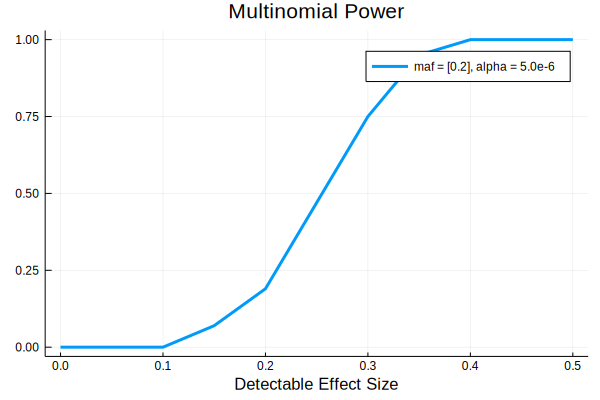

In [29]:
plot(γs, power_effectsize, title = "Multinomial Power", label = "maf = $maf_causal_snp, alpha = $α", lw = 3) # plot power
xlabel!("Detectable Effect Size")

### `Try it Yourself Exercises: `

With the remaining time we encourage you to play with the simulation models above. 

(1) If you change the significance level, α, what would happen to the plot of the power? How would the plot change with a smaller value of α ? 

(2) What if you change the sample size to be smaller than `n = 5000`? How does the power look as a function of the effect size when `n = 2500`? 

(3) What if we changed the minor allele frequency of the SNP of interest from `maf = 0.2` to say `maf = 0.3` ?

## Citations: 

[1] Lange K, Papp JC, Sinsheimer JS, Sripracha R, Zhou H, Sobel EM (2013) Mendel: The Swiss army knife of genetic analysis programs. Bioinformatics 29:1568-1570.`


[2] OPENMENDEL: a cooperative programming project for statistical genetics.
[Hum Genet. 2019 Mar 26. doi: 10.1007/s00439-019-02001-z](https://www.ncbi.nlm.nih.gov/pubmed/?term=OPENMENDEL).

[3] German, CA, Sinsheimer, JS, Klimentidis, YC, Zhou, H, Zhou, JJ. Ordered multinomial regression for genetic association analysis of ordinal phenotypes at Biobank scale. Genetic Epidemiology. 2019; 1– 13. https://doi.org/10.1002/gepi.22276
